In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import re

%matplotlib inline  
pd.set_option('display.max_columns', None)

In [2]:
mem = pd.read_csv('../data/NSS_GreatCare_Members.csv')
adm = pd.read_csv('../data/NSS_Hospital_Inpatient_Admissions.csv')
pcp = pd.read_csv('../data/NSS_PrimaryCare_Office_Visits.csv', low_memory = False)
pcp.head(5)

,Encounter ID,Patient ID,Service Provider ID,Attending Provider ID,Provider Group Provider ID,Facility Provider ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Attending Provider NPI,Facility Provider NPI,Service Provider NPI,Provider Group NPI,Encounter Date,Is Qualifying Preventive Primary Care Service,Is Qualifying Primary Care Service Provider,Is Qualifying Primary Care Attending,Is Qualifying Primary Care Provider Group,Qualifying Preventive Primary Care HCPCS Code
0,COV|EE|DS1|10076|20110225|DS1|NPI|1487856779,DS1|10076,DS1|NPI|1487856779,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.487857e+09,1.043427e+09,2011-02-18,0,1,0,0,NaN
1,COV|EE|DS1|10088|20140222|DS1|NPI|1528030996,DS1|10088,DS1|NPI|1528030996,DS1|NPI|1528030996,DS1|NPI|1043427248,DS1|NPI|1902803315,DS1|1,DS1|5047W,1.528031e+09,1.902803e+09,1.528031e+09,1.043427e+09,2014-02-22,0,1,1,1,NaN
2,COV|EE|DS1|10165|20140907|DS1|NPI|1477579365,DS1|10165,DS1|NPI|1477579365,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.477579e+09,1.043427e+09,2014-08-31,0,1,0,0,NaN
3,COV|EE|DS1|10240|20130624|DS1|NPI|1821178088,DS1|10240,DS1|NPI|1821178088,DS1|NPI|1821178088,DS1|NPI|1407058787,DS1|NPI|1104842020,DS1|1,DS1|5047W,1.821178e+09,1.104842e+09,1.821178e+09,1.407059e+09,2013-06-17,0,1,1,1,NaN
4,COV|EE|DS1|10293|20160904|DS1|NPI|1609004191,DS1|10293,DS1|NPI|1609004191,NaN,DS1|NPI|1184722779,NaN,DS1|1,DS1|5047X,NaN,NaN,1.609004e+09,1.184723e+09,2016-09-04,0,1,0,0,NaN


two[['First','second','third','fourth','fifth','sixth','Last']] = two['Encounter ID'].apply(
   lambda x: pd.Series(str(x).split("|")))
two.head()

In [3]:
#set datetime
adm['Encounter Start Date'] = pd.to_datetime(adm['Encounter Start Date'], format='%Y-%m-%d')
adm['Encounter End Date'] = pd.to_datetime(adm['Encounter End Date'], format='%Y-%m-%d')
pcp['Encounter Date'] = pd.to_datetime(pcp['Encounter Date'], format='%Y-%m-%d')

# MVP 1 
What is our 30-day all cause readmission rate across hospitals our members are admitted to?

In [4]:
#clean and transform dfs
#order by patient then start date
one = adm.sort_values(['Patient ID',"Encounter Start Date", "Encounter End Date"], ascending = (False, True, True))
#To calculate the days between admissions:
#shift previous end date to next row correct format and calculate
one['Previous End Date'] = (one.groupby('Patient ID')['Encounter End Date'].shift(1))
one['Previous End Date'] = pd.to_datetime(one['Previous End Date'], format='%Y-%m-%d')
one['Days Since Last Visit'] = one['Encounter Start Date'] - one['Previous End Date']

#ad_count is the total number of admissions
adm_count = len(one)
adm_count

6213

#Different Direction<br>
#if difference between Encounter End Date and Encounter Start Date 
one['diff'] = one.groupby('Patient ID')['Encounter Start Date'].diff() / np.timedelta64(1, 'D')
one['diff'] = one['diff'].fillna(0)
one['diff_end'] = one.groupby('Patient ID')['Encounter End Date'].diff() / np.timedelta64(1, 'D')
one['diff_end'] = one['diff_end'].fillna(0)
#length of stay - not grouped by
one['length'] = one['Encounter End Date']-one['Encounter Start Date'] 
one['length'] = one['length'].fillna(0)

In [5]:
#filter for readmission and within 30 days
one_top = one
one_top = one_top[one_top['Days Since Last Visit'].notnull()]
one_top = one_top[one_top['Days Since Last Visit'] <= '30 days']
one_top = one_top[one_top['Days Since Last Visit'] >= '0 days']

#read_count is the number of patients who were readmitted within 30 days of their prior adm
read_count = len(one_top)

In [6]:
#find the readmission rate1
read_rate = round(read_count/adm_count *100,2)
read_rate

11.31

In [7]:
#find the unique readmission rate 
read_rate_unique = round(one_top['Patient ID'].nunique() / one['Patient ID'].nunique()*100,2)
read_rate_unique

9.47

# Visualize it


In [8]:
# new variables
one_top['year'] = pd.DatetimeIndex(one_top['Encounter Start Date']).year
one_top.head()

,Encounter ID,Patient ID,Encounter Primary Payor ID,Encounter Primary Plan ID,Facility Provider ID,Attending Provider ID,Attending Provider NPI,Facility Provider NPI,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Previous End Date,Days Since Last Visit,year
6211,HIA|DS1|9994|DS1|NPI|1689608150|2,DS1|9994,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1750544516,1.750545e+09,1689608150,2015-11-24,2015-11-27,0,0,2.0,1,1,21.0,NaN,NaN,O42.92,"Full-term premature rupture of membranes, unsp...",0,19919.42,250.0,2015-11-23,1 days,2015
6202,HIA|DS1|9943|DS1|NPI|1184722779|2,DS1|9943,DS1|1,DS1|5047X,DS1|NPI|1184722779,DS1|NPI|1942320288,1.942320e+09,1184722779,2013-10-25,2013-10-28,1,0,1.0,1,6,21.0,NaN,NaN,K91.89,Other postprocedural complications and disorde...,0,12277.13,0.0,2013-10-16,9 days,2013
6199,HIA|DS1|9935|DS1|NPI|1902803315|1,DS1|9935,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1972545085,1.972545e+09,1902803315,2011-01-25,2011-01-26,0,0,2.0,4,62,21.0,NaN,NaN,I63.211,Cerebral infarction due to unspecified occlusi...,0,13596.10,250.0,2011-01-24,1 days,2011
6197,HIA|DS1|9935|DS1|NPI|1366401333|1,DS1|9935,DS1|1,DS1|5047X,DS1|NPI|1366401333,DS1|NPI|1790917086,1.790917e+09,1366401333,2011-01-26,2011-02-07,0,0,2.0,D,6,21.0,NaN,NaN,I63.211,Cerebral infarction due to unspecified occlusi...,0,45890.00,250.0,2011-01-26,0 days,2011
6185,HIA|DS1|9809|DS1|NPI|1689608150|2,DS1|9809,DS1|1,DS1|5047W,DS1|NPI|1689608150,DS1|NPI|1821297797,1.821298e+09,1689608150,2013-01-20,2013-01-24,0,0,2.0,1,1,21.0,NaN,NaN,I48.0,Paroxysmal atrial fibrillation,0,10721.07,250.0,2013-01-11,9 days,2013


HISTOGRAM

In [60]:
#filter for number of readmissions per patient
read_count_patient = one_top.groupby(['Patient ID'], as_index=False).count()
read_count_patient = read_count_patient.sort_values(['Patient ID'], ascending = (False))
read_count_patient_high = read_count_patient[read_count_patient['Encounter ID'] >= 0]

In [58]:
#filter for number of readmissions per Hospital
read_count_hospital = one_top.groupby(['Facility Provider NPI'], as_index=False).count()
read_count_hospital = read_count_hospital.sort_values(['Patient ID'], ascending = (False))
read_count_hospital_high = read_count_hospital[read_count_hospital['Encounter ID'] >= 5]

In [59]:
#filter for number of readmissions per Attendant 
read_count_attendant = one_top.groupby(['Attending Provider NPI'], as_index=False).count()
read_count_attendant = read_count_attendant.sort_values(['Patient ID'], ascending = (False))
read_count_attendant_high = read_count_attendant[read_count_attendant['Encounter ID'] >= 5]

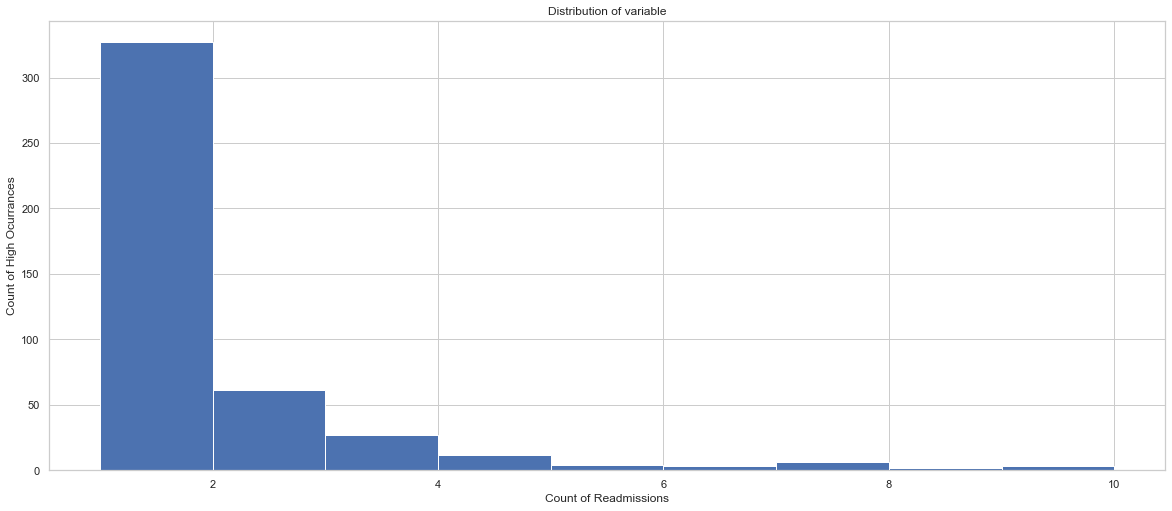

In [61]:
#filter for number of readmissions per patient
occurance1 = read_count_patient_high
bin1 = 9
#filter for number of readmissions per Hospital
occurance2 = read_count_hospital_high
bin2 = 7
#filter for number of readmissions per Attendant 
occurance3 = read_count_attendant_high
bin3 = 7

_= plt.hist('Encounter ID', bins = bin1, data = occurance1)
_= plt.title('Distribution of variable')
_= plt.ylabel('Count of High Ocurrances')
_= plt.xlabel('Count of Readmissions')

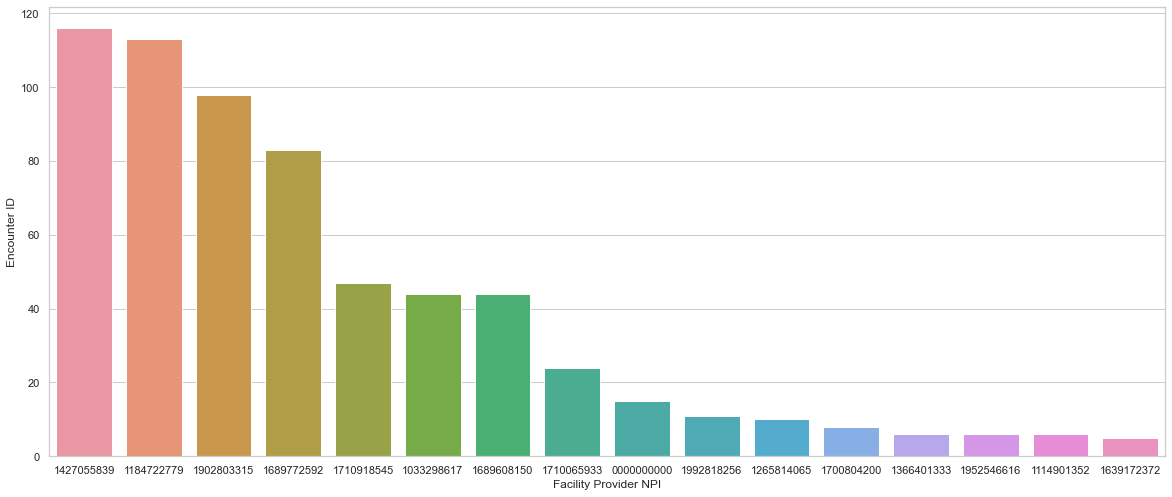

In [67]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Facility Provider NPI', y='Encounter ID',  data=occurance2)


LINE CHARTS

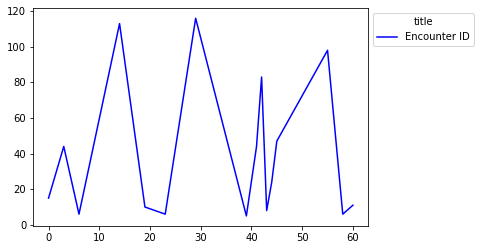

In [13]:
#filter for number of readmissions per patient
occurance1 = read_count_patient_high
#filter for number of readmissions per Hospital
occurance2 = read_count_hospital_high
#filter for number of readmissions per Attendant 
occurance3 = read_count_attendant_high

ax = plt.gca()
#_=occurance1['Encounter ID'].plot(kind='line', color = 'red', x ='Variable',y ='Count', ax = ax)
_=occurance2['Encounter ID'].plot(kind='line', color = 'blue', x ='Variable',y ='Count', ax = ax)
_=plt.legend(title='title', bbox_to_anchor=(1, 1), loc='upper left')

PAIR PLOT

In [14]:
#pair = one_top.groupby(['Facility Provider NPI'], as_index=False)
#sns.set(style="ticks", color_codes=True)
#sns.pairplot(pair);


VIOLIN PLOT

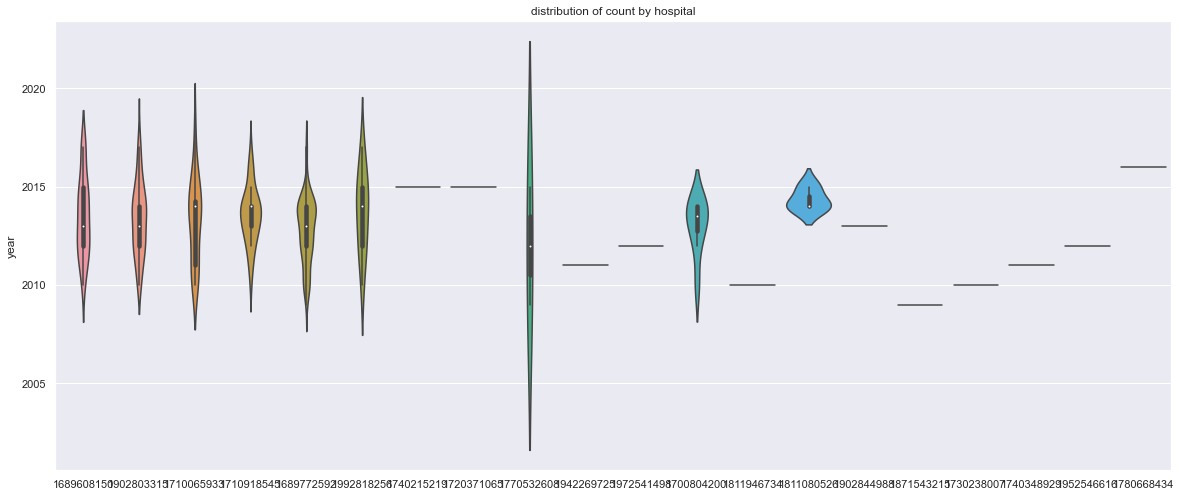

In [15]:
sns.set(rc={'figure.figsize':(20,8.27)})
violin = one_top[one_top['Facility Provider NPI'] >= '1689608150']
sns.violinplot(y=violin['year'], x = violin['Facility Provider NPI'])
plt.title('distribution of count by hospital')
plt.xlabel('');

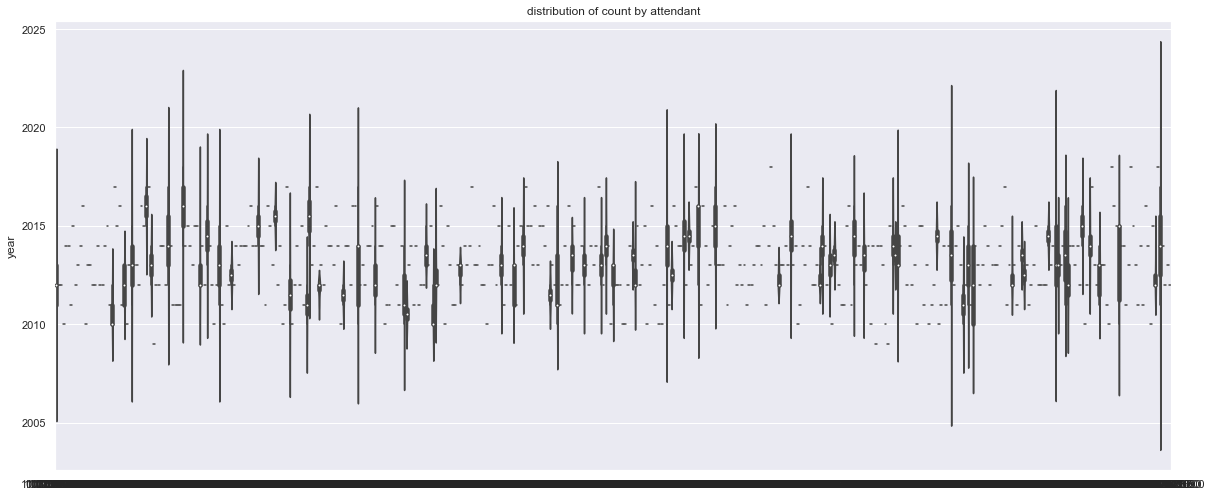

In [16]:
sns.violinplot(y=one_top['year'], x = one_top['Attending Provider NPI'])
plt.title('distribution of count by attendant')
plt.xlabel('');

# MVP 2
What percent of patients have a PCP visit within a week of discharge?

In [28]:
two = adm.merge(pcp, left_on ='Patient ID', right_on = 'Patient ID',how='left', indicator = False)
#sub encounter date from end dates
two['Days Since Last Visit'] = two['Encounter Date'] - two['Encounter End Date']
two_top = two[two['Days Since Last Visit'] <= '7 days']
two_top = two_top[two_top['Days Since Last Visit'] >= '0 days']
#count
count_two_top = len(two_top)
two_top.head(2)

,Encounter ID_x,Patient ID,Encounter Primary Payor ID_x,Encounter Primary Plan ID_x,Facility Provider ID_x,Attending Provider ID_x,Attending Provider NPI_x,Facility Provider NPI_x,Encounter Start Date,Encounter End Date,Is Emergency Department Visit Parent Encounter,Is Observation Stay Parent Encounter,CMS Admit Type Code,CMS Admit Source Code,CMS Patient Discharge Status Code,CMS Place of Service Code,Principal Discharge Diagnosis ICD-9-CM Code,Principal Discharge Diagnosis ICD-9-CM Description,Principal Discharge Diagnosis ICD-10-CM Code,Principal Discharge Diagnosis ICD-10-CM Description,Primary Plan Allowed Amount,Primary Plan Paid Amount,Patient Paid Amount,Encounter ID_y,Service Provider ID,Attending Provider ID_y,Provider Group Provider ID,Facility Provider ID_y,Encounter Primary Payor ID_y,Encounter Primary Plan ID_y,Attending Provider NPI_y,Facility Provider NPI_y,Service Provider NPI,Provider Group NPI,Encounter Date,Is Qualifying Preventive Primary Care Service,Is Qualifying Primary Care Service Provider,Is Qualifying Primary Care Attending,Is Qualifying Primary Care Provider Group,Qualifying Preventive Primary Care HCPCS Code,Days Since Last Visit
17,HIA|DS1|10043|DS1|NPI|1902803315|1,DS1|10043,DS1|1,DS1|5047Y,DS1|NPI|1902803315,DS1|NPI|1669599197,1.669599e+09,1902803315,2014-01-05,2014-01-12,0,0,3.0,1,1,21.0,348.4,Compression of brain,NaN,NaN,0,46465.40,250.0,COV|PBSL|DS1|10043|P|538933|1043427248|1|SHIFTED,DS1|NPI|1619199791,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047W,NaN,NaN,1.619200e+09,1.043427e+09,2014-01-12,0.0,1.0,0.0,0.0,NaN,0 days
28,HIA|DS1|10073|DS1|NPI|1902803315|1,DS1|10073,DS1|1,DS1|5047X,DS1|NPI|1902803315,DS1|NPI|1407880511,1.407881e+09,1902803315,2012-06-13,2012-06-21,1,0,1.0,1,1,21.0,NaN,NaN,K91.71,Accidental puncture and laceration of a digest...,0,43879.13,250.0,COV|PBSL|DS1|10073|P|301709|1043427248|1|SHIFTED,DS1|NPI|1659394021,NaN,DS1|NPI|1043427248,NaN,DS1|1,DS1|5047X,NaN,NaN,1.659394e+09,1.043427e+09,2012-06-27,0.0,1.0,0.0,0.0,NaN,6 days


In [26]:
#find the pcp visit within 7 days rate
pcp_visit_rate = round(count_two_top/adm_count *100,2)
pcp_visit_rate

38.23

In [76]:
#filter for number of readmissions per patient
pcp_count_patient = two_top.groupby(['Facility Provider NPI_x'], as_index=False).count()
pcp_count_patient = pcp_count_patient.sort_values(['Encounter ID_x'], ascending = (False))
pcp_count_patient_high =pcp_count_patient[pcp_count_patient['Encounter ID_x'] >= 5]

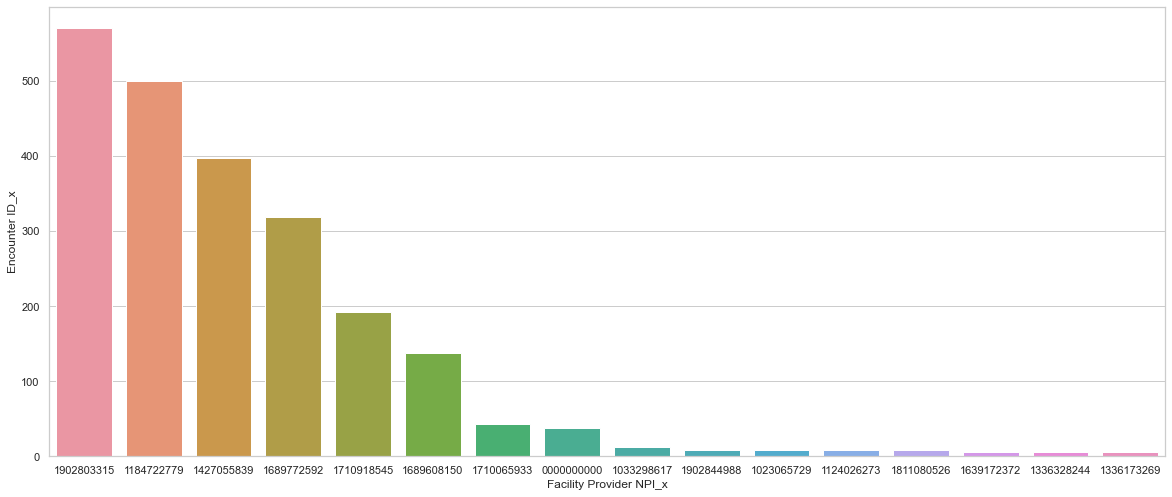

In [75]:
sns.set_theme(style="whitegrid")
ax = sns.barplot(x='Facility Provider NPI_x', y='Encounter ID_x',  data=pcp_count_patient_high)

# Question 3
Do either vary by individual or group PCP's?